# Group Classifier Validation

Load a trained group classifier model and generate validation plots:
- Load model from checkpoint
- Load validation data
- Generate predictions
- Create evaluation plots (confusion matrices, ROC curves, precision-recall, loss curves)


In [1]:
import json
import torch
import numpy as np
from pathlib import Path
from datetime import datetime
from typing import Optional

from pioneerml.zenml import utils as zenml_utils
from pioneerml.models.classifiers.group_classifier import GroupClassifier
from pioneerml.data import CLASS_NAMES, NUM_GROUP_CLASSES
from pioneerml.data.loaders import load_preprocessed_time_groups
from pioneerml.training.datamodules import GroupClassificationDataModule
from pioneerml.training.lightning import GraphLightningModule
from pioneerml.evaluation.plots import (
    plot_loss_curves,
    plot_multilabel_confusion_matrix,
    plot_precision_recall_curves,
    plot_roc_curves,
    plot_embedding_space,
    plot_probability_distributions,
    plot_confidence_analysis,
)

PROJECT_ROOT = zenml_utils.find_project_root()
checkpoints_dir = Path(PROJECT_ROOT) / "trained_models" / "group_classifier"
checkpoints_dir.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Checkpoints directory: {checkpoints_dir}")





Project root: /home/jack/python_projects/pioneerML
Checkpoints directory: /home/jack/python_projects/pioneerML/trained_models/group_classifier


## List Available Checkpoints

Find all saved model checkpoints and their metadata files.


In [2]:
# Find all checkpoint files
checkpoint_files = sorted(checkpoints_dir.glob("group_classifier_*.pt"), reverse=True)
metadata_files = sorted(checkpoints_dir.glob("group_classifier_*_metadata.json"), reverse=True)

print(f"Found {len(checkpoint_files)} checkpoint(s):")
for i, ckpt in enumerate(checkpoint_files, 1):
    print(f"  {i}. {ckpt.name}")
    # Find corresponding metadata
    timestamp = ckpt.stem.replace("group_classifier_", "")
    metadata_file = checkpoints_dir / f"group_classifier_{timestamp}_metadata.json"
    if metadata_file.exists():
        with open(metadata_file) as f:
            meta = json.load(f)
        print(f"     Timestamp: {meta.get('timestamp', 'unknown')}")
        print(f"     Run: {meta.get('run_name', 'unknown')}")
        if 'model_architecture' in meta:
            arch = meta['model_architecture']
            print(f"     Architecture: hidden={arch.get('hidden')}, num_blocks={arch.get('num_blocks')}, dropout={arch.get('dropout')}")

# Select the most recent checkpoint by default
selected_checkpoint = checkpoint_files[0] if checkpoint_files else None
selected_metadata = None
if selected_checkpoint:
    timestamp = selected_checkpoint.stem.replace("group_classifier_", "")
    metadata_file = checkpoints_dir / f"group_classifier_{timestamp}_metadata.json"
    if metadata_file.exists():
        with open(metadata_file) as f:
            selected_metadata = json.load(f)
        print(f"\nSelected checkpoint: {selected_checkpoint.name}")
        print(f"Metadata loaded from: {metadata_file.name}")
else:
    print("\nNo checkpoints found! Train a model first.")


Found 2 checkpoint(s):
  1. group_classifier_20251203_112338.pt
     Timestamp: 20251203_112338
     Run: group_classification_optuna_pipeline-2025_12_03-08_33_51_957863
     Architecture: hidden=128, num_blocks=4, dropout=0.1675984580563084
  2. group_classifier_20251203_012349.pt
     Timestamp: 20251203_012349
     Run: group_classification_optuna_pipeline-2025_12_03-06_19_29_909700
     Architecture: hidden=256, num_blocks=4, dropout=0.21067719814450897

Selected checkpoint: group_classifier_20251203_112338.pt
Metadata loaded from: group_classifier_20251203_112338_metadata.json


## Load Model

Reconstruct the model architecture from metadata and load the saved weights.


In [3]:
if selected_checkpoint is None or selected_metadata is None:
    raise ValueError("No checkpoint or metadata found. Please train a model first.")

# Extract model architecture from metadata
arch = selected_metadata.get("model_architecture", {})
best_params = selected_metadata.get("best_hyperparameters", {})

# Use architecture params from metadata, fallback to best_params
hidden = arch.get("hidden") or best_params.get("hidden", 192)
num_blocks = arch.get("num_blocks") or best_params.get("num_blocks", 3)
dropout = arch.get("dropout") or best_params.get("dropout", 0.1)
num_classes = arch.get("num_classes") or NUM_GROUP_CLASSES

print(f"Reconstructing model with:")
print(f"  hidden: {hidden}")
print(f"  num_blocks: {num_blocks}")
print(f"  dropout: {dropout}")
print(f"  num_classes: {num_classes}")

# Create model with same architecture
model = GroupClassifier(
    hidden=int(hidden),
    num_blocks=int(num_blocks),
    dropout=float(dropout),
    num_classes=int(num_classes),
)

# Load state dict
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_dict = torch.load(selected_checkpoint, map_location=device)
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

print(f"\nModel loaded successfully on {device}")
print(f"  Checkpoint: {selected_checkpoint.name}")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")


Reconstructing model with:
  hidden: 128
  num_blocks: 4
  dropout: 0.1675984580563084
  num_classes: 3

Model loaded successfully on cuda
  Checkpoint: group_classifier_20251203_112338.pt
  Parameters: 1,061,124


## Load Validation Data

Load the same data pattern used during training (or a subset for faster validation).


In [4]:
# Load validation data
# Use the same file pattern as training, or specify a different one
file_pattern = str(Path(PROJECT_ROOT) / "data" / "mainTimeGroups_*.npy")

# For validation, use full available data (no limiting by default)
validation_groups = load_preprocessed_time_groups(
    file_pattern,
    max_files=1,
    limit_groups=None,
    min_hits=2,
    min_hits_per_label=2,
    verbose=True,
)

print(f"Loaded {len(validation_groups)} groups for validation")

# Create datamodule
# val_split=0.0 means we use the full set (train split) for evaluation here
# to avoid unintended downsampling that was previously happening.
datamodule = GroupClassificationDataModule(
    records=validation_groups,
    num_classes=NUM_GROUP_CLASSES,
    batch_size=128,
    num_workers=0,  # Set to 0 for validation to avoid multiprocessing issues
    val_split=0.0,
    test_split=0.0,
    seed=42,
)
datamodule.setup(stage="fit")

val_dataset = datamodule.val_dataset or datamodule.train_dataset
if val_dataset is None:
    raise ValueError("No validation dataset available")

print(f"Validation dataset size: {len(val_dataset)}")



Limiting to 1 files (from 11 total files found, max_files=1)
Loaded 29370 groups from 1 files (pion: 10000, muon: 9998, mip: 9998)


Loaded 29370 groups for validation
Validation dataset size: 29370


## Generate Predictions

Run inference on the validation dataset.


In [5]:
from torch_geometric.loader import DataLoader

# Create dataloader
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0)

# Generate predictions
all_predictions = []
all_targets = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device)
        preds = model(batch)
        all_predictions.append(preds.cpu())
        all_targets.append(batch.y.cpu())

# Concatenate all predictions and targets
predictions = torch.cat(all_predictions, dim=0)
targets = torch.cat(all_targets, dim=0)

print(f"Generated predictions:")
print(f"  Predictions shape: {predictions.shape}")
print(f"  Targets shape: {targets.shape}")
print(f"  Predictions range: [{predictions.min():.4f}, {predictions.max():.4f}]")



Generated predictions:
  Predictions shape: torch.Size([29370, 3])
  Targets shape: torch.Size([88110])
  Predictions range: [-91.1414, 54.9559]


## Generate Validation Plots

Create comprehensive evaluation plots to assess model performance.


In [6]:
# Create output directory for plots
plots_dir = Path(PROJECT_ROOT) / "artifacts" / "validation_plots" / "group_classifier"
plots_dir.mkdir(parents=True, exist_ok=True)

timestamp_str = selected_metadata.get("timestamp", datetime.now().strftime("%Y%m%d_%H%M%S"))
plot_prefix = f"group_classifier_{timestamp_str}"

# Get class names from metadata or use defaults
dataset_info = selected_metadata.get("dataset_info", {})
class_names = dataset_info.get("class_names", list(CLASS_NAMES.values()))

print(f"Generating validation plots in: {plots_dir}")
print(f"Class names: {class_names}")


Generating validation plots in: /home/jack/python_projects/pioneerML/artifacts/validation_plots/group_classifier
Class names: ['pion', 'muon', 'mip']


### Confusion Matrix

The confusion matrix shows how well the model classifies each particle type. It displays the true labels vs predicted labels in a grid format.

**How to interpret:**
- **Diagonal elements** (top-left to bottom-right): Correct predictions. Higher values indicate better performance for that class.
- **Off-diagonal elements**: Misclassifications. Shows which classes are being confused with each other.
- **Normalized values**: Percentages show the proportion of each true class that was predicted as each class. A perfect classifier would have 100% on the diagonal and 0% elsewhere.
- **Class imbalance**: If one class has many more samples, it may appear to perform better simply due to volume. Check the normalized matrix to see true performance.

**What to look for:**
- High diagonal values indicate good classification
- Off-diagonal patterns reveal systematic confusions



1. Generating confusion matrix...


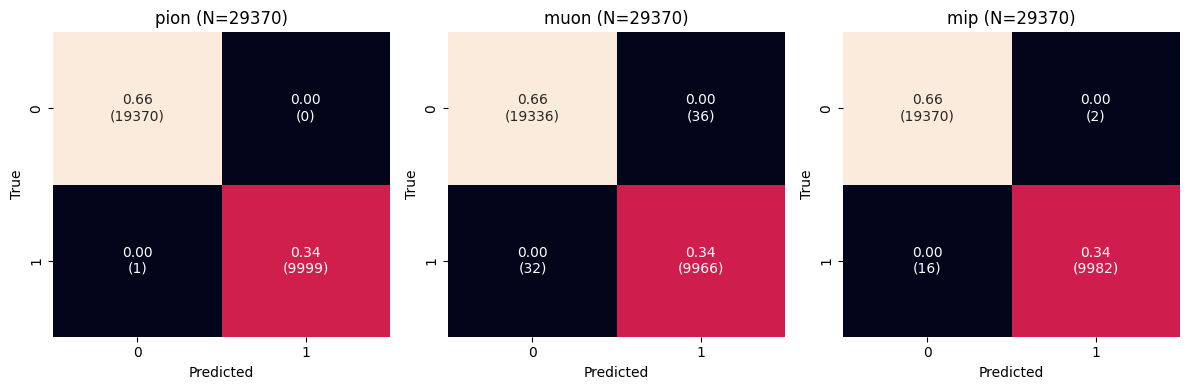

In [7]:
# 1. Confusion Matrix
print("\n1. Generating confusion matrix...")
confusion_path = plots_dir / f"{plot_prefix}_confusion_matrix.png"
plot_multilabel_confusion_matrix(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    threshold=0.5,
    normalize=True,
    show=True,
)


### ROC Curves (Receiver Operating Characteristic)

ROC curves show the trade-off between the true positive rate (sensitivity) and false positive rate (1 - specificity) at different classification thresholds.

**How to interpret:**
- **X-axis (False Positive Rate)**: Proportion of negative samples incorrectly classified as positive. Lower is better.
- **Y-axis (True Positive Rate / Recall)**: Proportion of positive samples correctly identified. Higher is better.
- **Diagonal line (AUC = 0.5)**: Random guessing baseline. Any curve above this indicates the model is learning.
- **AUC (Area Under Curve)**: 
  - AUC = 1.0: Perfect classifier

**What to look for:**
- Curves that hug the top-left corner indicate better performance
- Higher AUC values mean the model can better distinguish between classes
- Compare curves across classes to identify which particle types are easier/harder to classify
- ROC curves are useful when classes are relatively balanced (i.e. ~equally likely to see each class from a random sample)



2. Generating ROC curves...


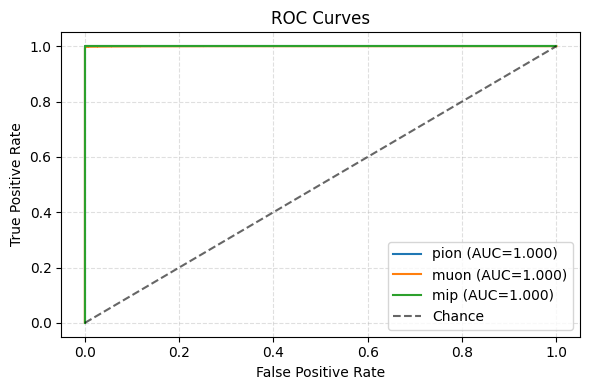

In [8]:
# 2. ROC Curves
print("\n2. Generating ROC curves...")
roc_path = plots_dir / f"{plot_prefix}_roc_curves.png"
plot_roc_curves(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    show=True,
)


### Precision-Recall Curves

Precision-Recall curves show the relationship between precision (accuracy of positive predictions) and recall (coverage of positive samples) at different thresholds.

**How to interpret:**
- **X-axis (Recall)**: Proportion of actual positives that were correctly identified. Also called sensitivity or true positive rate.
- **Y-axis (Precision)**: Proportion of predicted positives that are actually positive. Measures prediction quality.
- **AP (Average Precision)**: The area under the PR curve. It's computed by ranking predictions and averaging precision at each recall level, which is mathematically equivalent to integrating the PR curve. Higher values indicate better performance.

**What to look for:**
- Curves that stay high on the Y-axis (high precision) indicate confident, accurate predictions
- Curves that extend far right (high recall) mean the model finds most positive samples
- **Precision-Recall vs ROC**: PR curves are more informative than ROC when classes are imbalanced, as they focus on the positive class performance



3. Generating precision-recall curves...


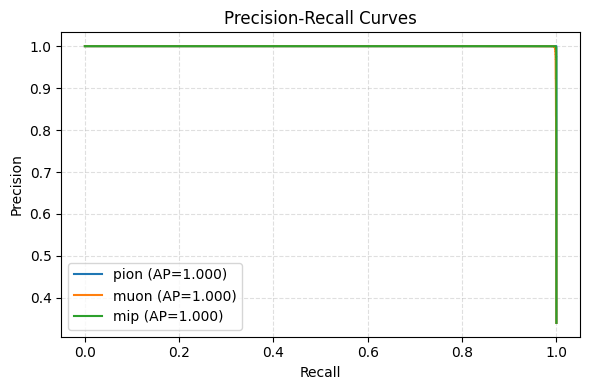

In [9]:
# 3. Precision-Recall Curves
print("\n3. Generating precision-recall curves...")
pr_path = plots_dir / f"{plot_prefix}_precision_recall.png"
plot_precision_recall_curves(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    show=True,
)


In [10]:
# Extract embeddings from the model
from torch_geometric.loader import DataLoader

model.eval()
embeddings_list = []
targets_list = []

with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device)
        # Extract embeddings (before classification head)
        emb = model.extract_embeddings(batch)
        embeddings_list.append(emb.cpu())
        targets_list.append(batch.y.cpu())

# Concatenate all embeddings and targets
embeddings = torch.cat(embeddings_list, dim=0)
targets_for_emb = torch.cat(targets_list, dim=0)

# Ensure targets align with embeddings (handle flattened labels)
if targets_for_emb.dim() == 1 and embeddings.shape[0] > 0:
    if targets_for_emb.numel() % embeddings.shape[0] == 0:
        targets_for_emb = targets_for_emb.view(embeddings.shape[0], -1)

print(f"Extracted embeddings:")
print(f"  Embeddings shape: {embeddings.shape}")
print(f"  Targets shape: {targets_for_emb.shape}")



Extracted embeddings:
  Embeddings shape: torch.Size([29370, 512])
  Targets shape: torch.Size([29370, 3])


### Embedding Space Visualization (t-SNE)

Visualize the learned embedding space using t-SNE to see how well the model separates different particle types. Read more ab

**How to interpret:**
- **t-SNE (t-Distributed Stochastic Neighbor Embedding)**: Reduces high-dimensional embeddings (512D) to 2D for visualization while preserving local neighborhood structure.
- **Clusters**: Well-separated clusters of different colors indicate the model has learned distinct representations for each particle type.
- **Overlap**: Overlapping clusters suggest the model struggles to distinguish between those classes, which may indicate similar features or insufficient training.
- **Tight clusters**: Compact, well-defined clusters indicate confident, consistent representations for each class.
- **Scattered points**: Widely scattered points of the same color suggest high variance in the learned features for that class.

**What to look for:**
- Clear separation between different particle types (pion, muon, mip) indicates good feature learning
- Minimal overlap between classes suggests the model can distinguish them well
- If classes are well-separated in embedding space, the classifier should perform well
- Note: t-SNE preserves local structure but distances between far-apart clusters may not be meaningful



Generating embedding space visualization (t-SNE)...


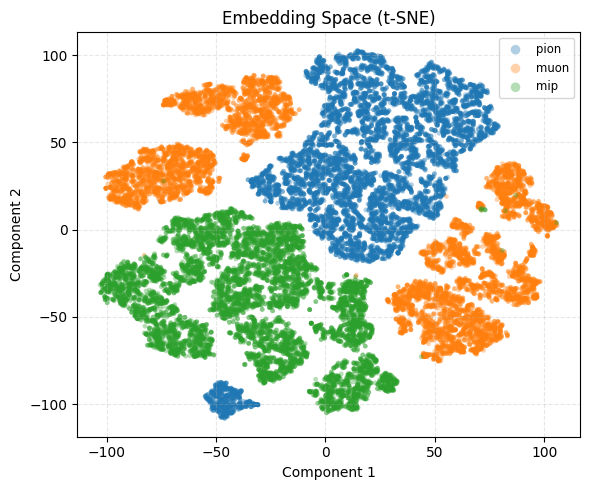

In [11]:
from pioneerml.evaluation.plots import plot_embedding_space

print("\nGenerating embedding space visualization (t-SNE)...")
embedding_path = plots_dir / f"{plot_prefix}_embedding_space_tsne.png"
plot_embedding_space(
    embeddings=embeddings,
    targets=targets_for_emb,
    class_names=class_names,
    method="tsne",
    perplexity=30.0,
    n_components=2,
    #save_path=embedding_path,
    show=True,
)


### Probability Distributions

Show how well separated the probability distributions are for each class. These plots display the predicted probabilities (after softmax) for each particle type.

**How to interpret:**
- **Probability values**: After applying softmax, predictions are converted to probabilities (0-1).
- **Histogram shape**: 
  - Sharp peak near 1.0 for correct class = confident, accurate predictions
  - Broad distribution = uncertain predictions
  - Peak near 0.0 for incorrect classes = good discrimination

**What to look for:**
- Strong peaks at high probability for the correct class indicate confident, accurate predictions
- Low probabilities for incorrect classes show good discrimination



Generating probability distribution plots...


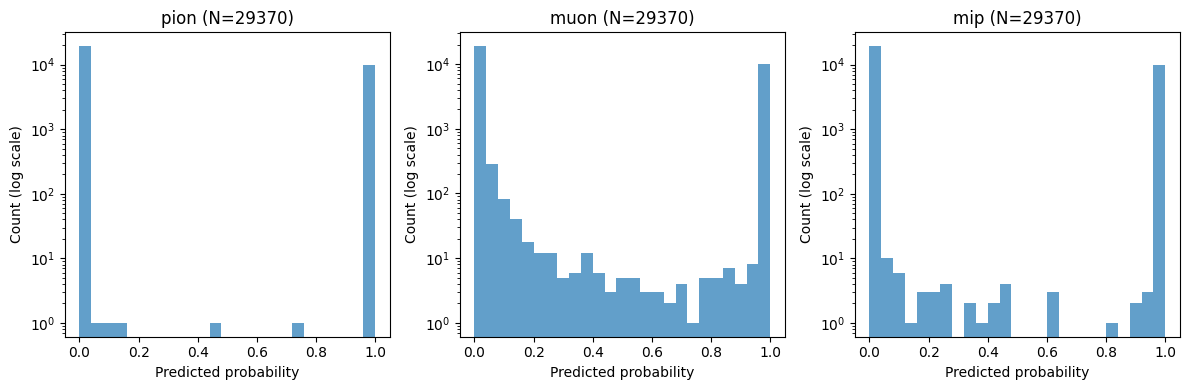

In [12]:
from pioneerml.evaluation.plots import plot_probability_distributions

print("\nGenerating probability distribution plots...")
plot_probability_distributions(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    show=True,
)
